In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/Documents/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult, MetabolismRedux


FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

Before running this, I ran a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment, where we e.g. have dynamic demand for amino acids and nucleotides, and varying cell volumes.

You don't have to do this for now. We'll use a single time step from the simulation output to test the network flow model on its own.

In [2]:
time = '50'
date = '2023-06-26'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [3]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [4]:
# this is the model itself - we'll pull e.g. stoichiometry from here.
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

metabolism = agent['ecoli-metabolism-redux']
stoichiometry = metabolism.stoichiometry

# Check molecule exchanges from simulation - sanity check.

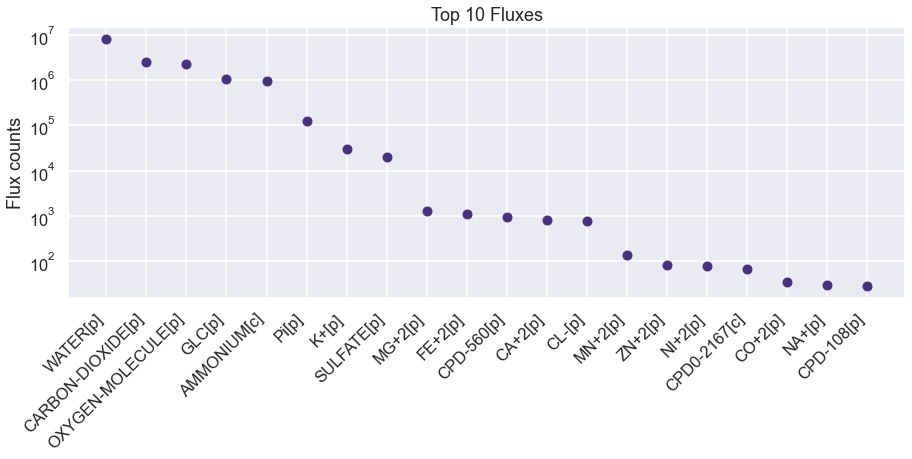

In [5]:
# sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
# sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))
#
# # plot the top 10 fluxes from sim_fluxes as a bar plot.
# plt.figure(figsize=(15, 5))
# plt.plot(sim_exchanges.head(20), 'o')
#
# # shorten all xtick names to 10 characters
# plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# # make xticks aligned to right left of bar
# plt.yscale('log')
# plt.ylabel('Flux counts')
# plt.title('Top 10 Fluxes')
# plt.show()

# Check reaction fluxes from simulation - sanity check.

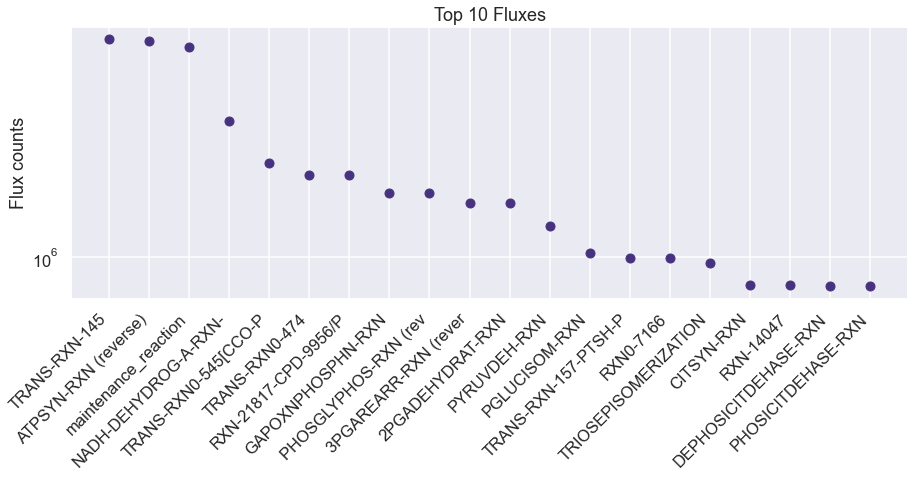

In [6]:
# sim_fluxes = pd.DataFrame(fba["estimated_fluxes"], columns = metabolism.reaction_names)
# sim_fluxes = pd.DataFrame(sim_fluxes.loc[24, :].abs().sort_values(ascending=False))
#
#
# # plot the top 10 fluxes from sim_fluxes as a bar plot.
# plt.figure(figsize=(15, 5))
# plt.plot(sim_fluxes.head(20), 'o')
#
# # shorten all xtick names to 10 characters
# plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# # make xticks aligned to right left of bar
#
#
# plt.ylabel('Flux counts')
# # log scale
# plt.yscale('log')
# plt.title('Top 10 Fluxes')
# plt.show()

In [7]:
# sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"], columns=metabolism.reaction_names)
# sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
# sim_catalysts

,4
RXN0-1741-MALTOSE//MALTOSE.17.,24833.0
RXN0-0-CPD0-1123//N-ACETYLNEURAMINATE.31.,24807.0
RXN-15315,24807.0
RXN0-0-CPD0-1122//CPD0-1122.21.,24807.0
RXN0-0-CPD0-1122//N-ACETYLNEURAMINATE.31.,24807.0
...,...
BETAGALACTOSID-RXN-Alpha-lactose/WATER//GALACTOSE/GLC.35.,0.0
BETAGALACTOSID-RXN-Alpha-lactose/WATER//GALACTOSE/Glucopyranose.45.,0.0
BETAGALACTOSID-RXN-CPD-15972/WATER//GALACTOSE/ALPHA-GLUCOSE.41.,0.0
BETAGALACTOSID-RXN-CPD-15972/WATER//GALACTOSE/GLC.31.,0.0


# Test changing nutrient composition

In [8]:
# uptake = metabolism.allowed_exchange_uptake
# uptake = set(uptake)
#
# # addition = set(["CPD0-1074[c]"])
# addition = set([
#         # "FRU[p]",
#         # "NITRATE[p]"
#         # 'THIAMINE[p]',
#         # 'HYDROGEN-MOLECULE[p]',
#         # 'FUM[p]'
# ])
# removals = set([
#                   # "GLC[p]",
#                #      # 'AMMONIUM[c]',
#                #      # 'WATER[p]'
#                #       # 'Pi[p]',
#                #       # 'SULFATE[p]'
#                # 'OXYGEN-MOLECULE[p]'
# ])
#
#
# uptake = uptake | addition
# uptake = uptake - removals
# uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [9]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

In [10]:
model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

In [11]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [12]:
objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
solution: FlowResult = model.solve(
            homeostatic_targets=np.array(list(dict(homeostatic).values())),
            maintenance_target=maintenance,
            kinetic_targets=np.array(list(dict(kinetic).values())),
            binary_kinetic_idx=[],
            objective_weights=objective_weights,
            upper_flux_bound=100000000)

In [13]:
pd.Series(solution.exchanges).abs().sort_values(ascending=False)

5182    8.249992e+06
639     2.490931e+06
4382    2.221422e+06
3617    1.074952e+06
446     9.069960e+05
            ...     
1775    0.000000e+00
1774    0.000000e+00
1773    0.000000e+00
1772    0.000000e+00
5313    0.000000e+00
Length: 5314, dtype: float64

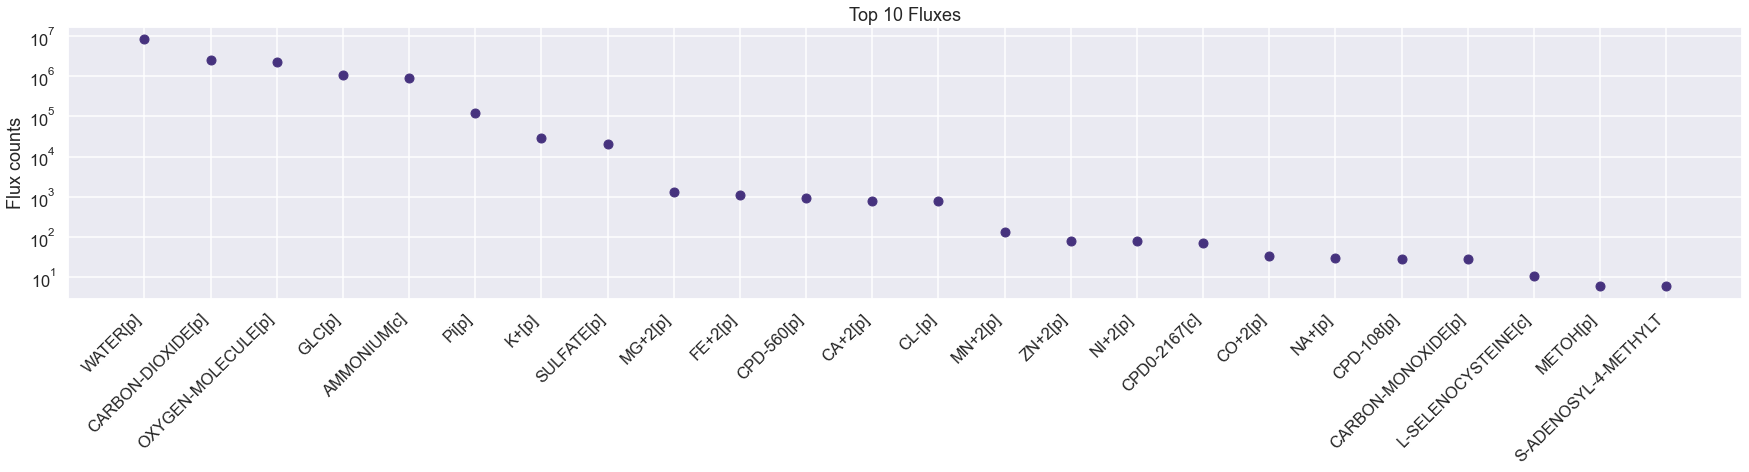

In [14]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

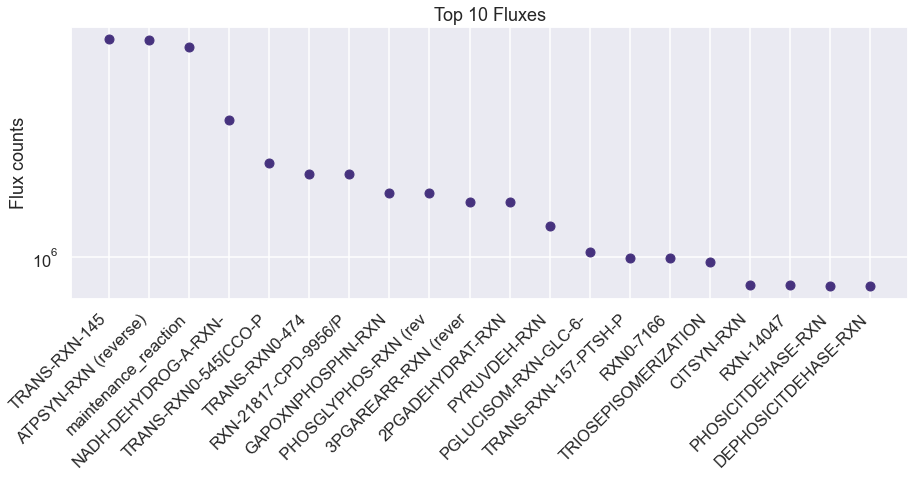

In [15]:
cur_fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

## Connect to EcoCyc to go from Genes -> Reactions

We use the EcoCyc API to automatically figure out what are made possible by the genes we are adding. While reactions are always possible, enzymes make them faster to the point that it is useful to the cell.

In [16]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [17]:
added_gene_to_reaction = {"EG10941": "putative-L-selenocysteine-synthesis"
                          # Associate added reactions with genes here
                          }

In [18]:
condition_df = pd.read_excel("notebooks/new_environments/temp.xlsx")
condition_df["Genes"] = condition_df["Genes"].apply(lambda x: set(x.split(", ") if x == x else set()))
condition_df["Add"] = condition_df["Add"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Remove"] = condition_df["Remove"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Demand"] = condition_df["Demand"].apply(lambda x: set(str(x).split(", ") if x == x else set()))
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df["Substrates"] = [[np.nan]] * len(condition_df)

condition_df

,Environment,Genes,Add,Remove,Demand,Reactions,Substrates
0,Testing L-Selenocysteine,{EG10941},"{SER[c], SEPO3[c]}",{},{L-SELENOCYSTEINE[c]},[nan],[nan]


In [19]:
length = len(condition_df.index)

for i in range(length):
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()
    added_rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]

        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)

        if gene in added_gene_to_reaction.keys():
            added_rxn_set.add(added_gene_to_reaction[gene])

    condition_df.at[i, "Reactions"] = rxn_set

    overall_list = []
    for reaction in rxn_set:
        compound_set = set()
        function = "substrates-of-reaction"
        name = reaction
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Compound']
        if type(o) is dict:
            o = [o]

        for compound in o:
            if type(compound) is not str:
                compound_set.add(compound['@frameid'])
            else:
                print(reaction, compound)

        overall_list.append(compound_set)

    condition_df.at[i, "Reactions"].update(added_rxn_set)
    condition_df.at[i, "Substrates"] = overall_list
    condition_df.loc[i + length] = [condition_df.at[i, "Environment"] + " CONTROL", set(), set(), set(), set(), condition_df.at[i, "Reactions"], []]
    # This is to create the control

In [20]:
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions,Substrates
0,Testing L-Selenocysteine,{EG10941},"{SER[c], SEPO3[c]}",{},{L-SELENOCYSTEINE[c]},"{2.9.1.1-RXN, putative-L-selenocysteine-synthe...","[{Pi, SEPO3}]"
1,Testing L-Selenocysteine CONTROL,{},{},{},{},"{2.9.1.1-RXN, putative-L-selenocysteine-synthe...",[]


## Quick and dirty loop (after init)

In [21]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])
zero_df = pd.DataFrame()
all_flux = []

metabolites_idx = {species: i for i, species in enumerate(metabolism.metabolite_names)}
reaction_catalysts = metabolism.parameters['reaction_catalysts']
metabolism.catalyst_ids = metabolism.parameters['catalyst_ids']
catalyst_idx = {catalyst: i for i, catalyst in enumerate(metabolism.catalyst_ids)}

reactions_add = {"putative-L-selenocysteine-synthesis": {'SEPO3[c]': -1, 'SER[c]': -1, 'Pi[c]': 1, 'L-SELENOCYSTEINE[c]': 1}
                 # Insert other added reactions here
                 }

for col_idx, (reaction, stoich) in enumerate(reactions_add.items()):
        new_col = np.zeros([len(metabolism.stoichiometry),1])
        metabolism.stoichiometry = np.append(metabolism.stoichiometry, new_col, axis=1)

        for species, coefficient in stoich.items():
            i = metabolites_idx[species]
            metabolism.stoichiometry[i, np.shape(metabolism.stoichiometry)[1] - 1] = coefficient

        # now adds an entry for every reaction, list can be empty
        reaction_catalysts["putative-L-selenocysteine-synthesis"] = ['CPLX0-1141[c]']
        # Taken from reconstruction/ecoli.../complexation reactions to find the complex that the gene forms
        enzyme_idx = [catalyst_idx[catalyst] for catalyst in reaction_catalysts.get(reaction, [])]
        metabolism.catalyzed_rxn_enzymes_idx.append(enzyme_idx)

for i in range(len(condition_df)):
    condition_idx = i

    uptake = metabolism.allowed_exchange_uptake

    homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :])
    new_demand = condition_df.at[condition_idx, "Demand"]
    if new_demand != set():
        for met in new_demand:
            homeostatic[met] = 100

    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    for gene in condition_df.at[i, "Genes"]:
        if gene in added_gene_to_reaction:
            metabolism.reaction_names.append(added_gene_to_reaction[gene])

    model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)

    objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
    solution: FlowResult = model.solve(
                homeostatic_targets=np.array(list(dict(homeostatic).values())),
                maintenance_target=maintenance,
                kinetic_targets=np.array(list(dict(kinetic).values())),
                binary_kinetic_idx=[],
                objective_weights=objective_weights,
                upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names)
    # fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux"]
    all_flux.append(fluxes)

    if condition_df.at[condition_idx, "Environment"][-7:] == "CONTROL":
        control_df = pd.DataFrame()
        flux_threshold = 100
        for j, k in enumerate(fluxes.index):
            if abs(all_flux[condition_idx - length][k] - fluxes[k]) / abs(fluxes[k] + 0.01) >= flux_threshold:
                control_df = control_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          fluxes.index[j],
                         (all_flux[condition_idx - length][k] - fluxes[k]) / (fluxes[k] + 0.01) ]], columns=["Environment", "Reaction", "(Experiment - Control)/(Control + 0.01) Flux"]))
        if len(control_df) > 0:
            control_df = control_df.sort_values(by=["(Experiment - Control)/(Control + 0.01) Flux"], ascending=False)
        control_df.to_csv(rf'notebooks/new_environments/figures/control_differences/{condition_df.at[condition_idx, "Environment"]}.csv')
    else:
        relevant_rxns = condition_df.at[condition_idx, "Reactions"]
        relevant_rxn_idx = []

        for rxn in relevant_rxns:
            relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

        relevant_fluxes = fluxes.iloc[relevant_rxn_idx]

        relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes != 0]
        zero_fluxes = relevant_fluxes[relevant_fluxes == 0]

        for j, k in enumerate(relevant_nonzero_fluxes.index):
            results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

        for j, k in enumerate(zero_fluxes.index):
            zero_df = zero_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          zero_fluxes.index[j],
                          zero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

    print(f"""Finished {condition_df.at[condition_idx, "Environment"]}""")
zero_df.to_csv(r'notebooks/new_environments/figures/zero_flux.csv')

Finished Testing L-Selenocysteine
Finished Testing L-Selenocysteine CONTROL


In [26]:
# results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df["log(Flux)"] = np.log10(results_df["Flux"])
results_df

<class 'pandas.core.series.Series'>


,Environment,Reaction,Flux,log(Flux)
0,Testing L-Selenocysteine,putative-L-selenocysteine-synthesis,100.0,2.0


In [23]:
# for each environment, plot the fluxes of the reactions that are relevant to that environment.
# g = sns.catplot(y="Environment",hue="Reaction", x="log(Flux)", data=results_df, kind="bar", aspect=2, height=10, sharey=False)
# g.savefig("notebooks/new_environments/figures/rxns_light_up.pdf")

In [24]:
import textwrap

def wrap_x_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

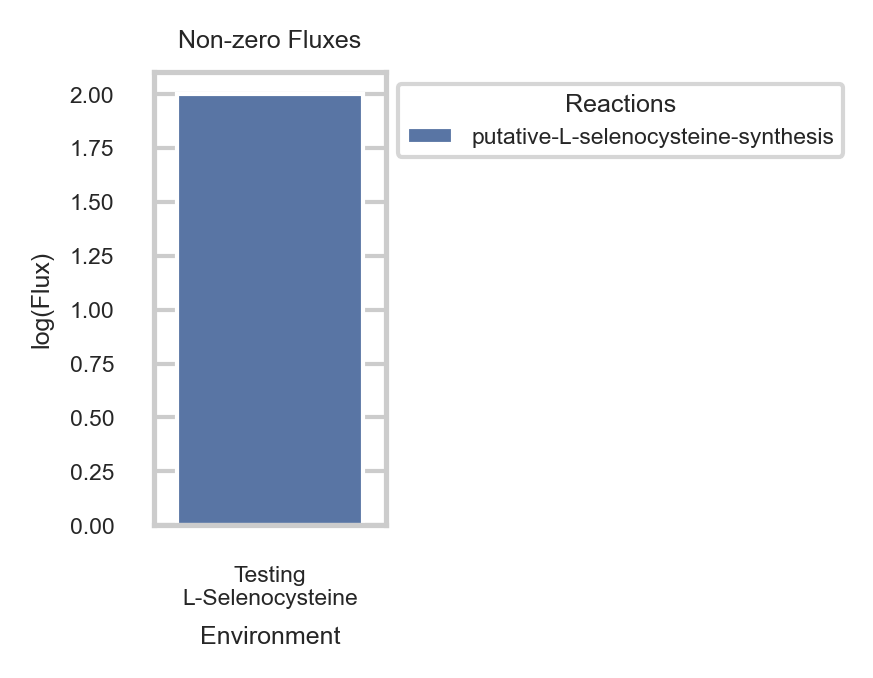

In [25]:
sns.set_theme(style="whitegrid", rc={'figure.dpi': 300}, font_scale=0.5)
fig, ax = plt.subplots(figsize=(len(results_df["Environment"].unique()), 2))
ax.set_title("Non-zero Fluxes")
ax = sns.barplot(data=results_df, x="Environment", y="log(Flux)", ax=ax, hue="Reaction")
ax.legend(bbox_to_anchor=(1, 1), title='Reactions', loc='upper left', ncol = 1)
wrap_x_labels(ax, 10)
fig = ax.get_figure()
plt.show(fig)
fig.savefig("notebooks/new_environments/figures/vert_bar_rxns.png")